<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Development of a Machine Learning Model for Accurate Prediction of HDB Prices

--- 
# Part 2

Data dictionary, baseline model, (Modeling,feature engineering, evaluating)

---

### Contents:
- [Data dictionary](#Data-dictionary)
- [Baseline model](#Baseline-model)
- [Modeling/Feature engineering/Evaluating](#Modeling/Feature-engineering/Evaluating)
- [Conclusion](#Conclusion)


### Structure

In this notebook, we will create a baseline model with some of the continuous features (such as area, hdb age) we identified in the previous part. The next step would be to engineer features to train a model to beat the baseline, then evaluating and repeating the above steps until we get a satisfactory performance. We will evaluate our model using k-fold cross validation with metrics RMSE.

## Data dictionary

There is only one dataset here, train-clean.csv, created in part 1.
|Feature|Type|Description|
|---|---|---|
|3room_sold|int|number of 3 room flats in the block the flat was sold|
|4room_sold|int|number of 4 room flats in the block the flat was sold|
|5room_sold|int|number of 5 room flats in the block the flat was sold|
|bus_stop_nearest_distance|float|distance (in metres) to the nearest bus stop|
|exec_sold|int|number of executive flats in the block the flat was sold|
|flat_model|object|HDB model of the resale flat|
|flat_type|object|type of the resale flat unit|
|floor_area_sqm|float|floor area of the resale flat unit in square metres|
|hawker_food_stalls|int|number of hawker food stalls in the nearest hawker centre|
|hawker_market_stalls|int|number of hawker and market stalls in the nearest hawker centre|
|hawker_nearest_distance|float|distance (in metres) to the nearest hawker centre|
|hawker_within_1km|int|number of hawker centres within 1 kilometre|
|hawker_within_2km|int|number of hawker centres within 2 kilometre|
|hawker_within_500m|int|number of hawker centres within 500 metres|
|hdb_age|int|number of years from lease commence date to present year(year the sale was made)|
|mall_nearest_distance|float|distance (in metres) to the nearest mall|
|mall_within_1km|int|number of malls within 1 kilometre|
|mall_within_2km|int|number of malls within 2 kilometre|
|mall_within_500m|int|number of malls within 500 metres|
|max_floor_lvl|int|highest floor of the block of resale flat|
|mid|int|middle value of storey range of the resale flat|
|mrt_nearest_distance|float|distance (in metres) to the nearest MRT station|
|planning_area|object|Government planning area that the flat is located|
|resale_price|float|the property's sale price in Singapore dollars. This is the target variable that we are trying to predict for this project.|
|total_dwelling_units|int|total number of residential dwelling units in the resale flat|
|tranc_month|int|year of resale transaction|
|tranc_year|int|month of resale transaction|


[Back to contents](#Contents:)

### Import stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFECV

pd.set_option("display.max_rows", 100)

In [2]:
df = pd.read_csv('../datasets/train-clean.csv')

Picking out the features which has to be StandardScaler-ed

In [3]:
continuous = df.columns.drop(['flat_model', 'flat_type', 'planning_area', 'resale_price'])

## Baseline model

We create a baseline model using LinearRegression and the following features. These are features which have shown a high correlation with resale price.

In [4]:
baseline = ['floor_area_sqm', 'mid', 'hdb_age', 'max_floor_lvl']

In [5]:
X_base = df[baseline]
y = df['resale_price']

In [6]:
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, 
                                                              y, 
                                                              test_size=0.2, 
                                                              random_state=42)

#scaling because we will be doing so later on. Easier to intepret.
ss = StandardScaler()
X_train_base = ss.fit_transform(X_train_base)
X_test_base = ss.transform(X_test_base)

In [7]:
lr_base = LinearRegression()
lr_base.fit(X_train_base, y_train)
lr_base_scores = -cross_val_score(lr_base, X_train_base, y_train, 
                                  scoring = 'neg_root_mean_squared_error')
lr_base_scores.mean()

84543.7735653718

The CV score based on RMSE is about 85k. We will try to create a model to beat this score.

In [8]:
#Test score
mean_squared_error(y_test, lr_base.predict(X_test_base)) ** 0.5

84241.96562765863

The similarity between test score and CV score indicates that there is little sampling error.

In [9]:
#Train score
mean_squared_error(y_train, lr_base.predict(X_train_base)) ** 0.5

84541.39475408602

The RMSE scores between test and train indicate that there is little variance. Although it seems the model "generalises" well, at this point in time, it is simply underfitted.

Taking a look at the coefficients,

In [10]:
pd.DataFrame(lr_base.coef_, index=baseline)

,0
floor_area_sqm,87104.895214
mid,18426.270513
hdb_age,6015.104569
max_floor_lvl,57572.956522


Per standard deviation, we find that price of a flat increases approximately:
- 87104 for area
- 18426 for floor the flat is on
- 6015 for hdb age
- 57572 for maximuum number of floors in the block

The age of a hdb seems to play the least role in determining prices.

[Back to contents](#Contents:)

## Modeling/Feature engineering/Evaluating

We will try to drastically increase the complexity of the model by building some polynomials of degree at most 3. We then proceed to check their correlation and discard those that fall below a certain threshold, which is again arbitrarily chosen, so that we do not lose ALL of the features.

In [11]:
poly = PolynomialFeatures(degree=3,interaction_only=True,include_bias=False)
X_poly = poly.fit_transform(df[continuous])
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(continuous))
df_poly['resale_price'] = y
df_poly_corr = df_poly.corr()
features = df_poly_corr[abs(df_poly_corr['resale_price']) > 0.5]['resale_price'].index
df_poly = df_poly[features]
df_poly.to_csv('datasets/poly-feat-deg-3.csv', index=False)

The below csv file was obtained with the code above, ran with degree = 3.It took >1200secs to run the block with degree = 3. For your convenience, we have saved a copy of the csv file for you to run so you do not have to wait that long.

In [12]:
df_poly = pd.read_csv('../datasets/poly-feat-deg-3.csv')

We now proceed to check the scores produced by a subset of these features. Notice that only area and max level is still in the list of features as standalone features. This is because the correlation coefficient threshold was increased to 0.5 from the previous 0.3. We will toss out those that "does not make sense" and check for multicollinearity after.

In [13]:
df[baseline].corr()

,floor_area_sqm,mid,hdb_age,max_floor_lvl
floor_area_sqm,1.000000,0.027494,-0.305761,0.080437
mid,0.027494,1.000000,-0.259764,0.552800
hdb_age,-0.305761,-0.259764,1.000000,-0.454025
max_floor_lvl,0.080437,0.552800,-0.454025,1.000000


<a id='sidenote'></a>**Side note:**
Notice how age and max level has a -0.45 correlation coefficient, this could indicate that newer hdb buildings are being built with more levels, and therefore max level affects housing prices because the buildings are new.

[Back](#back)

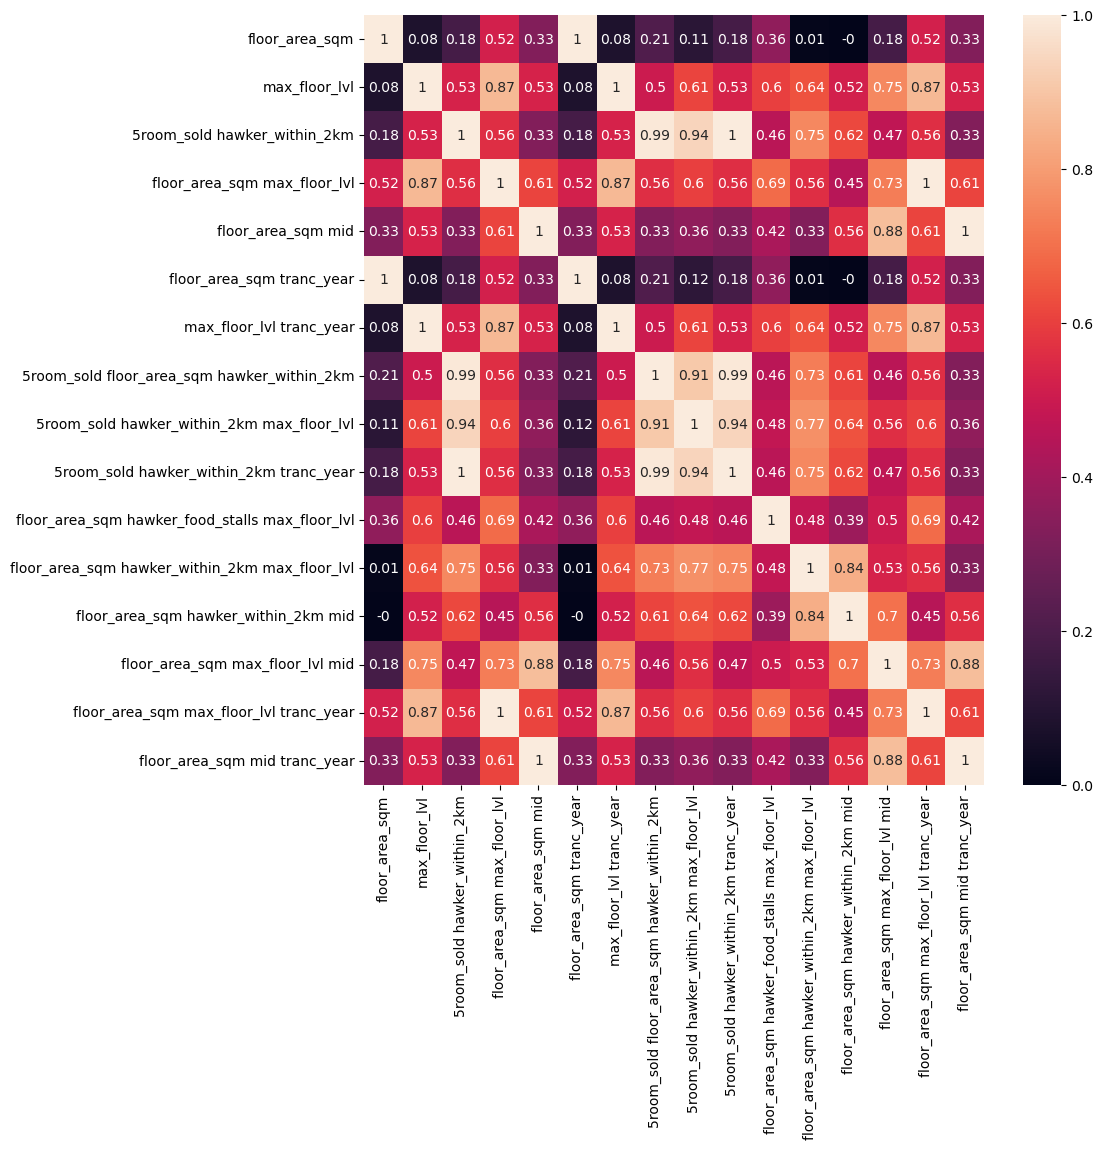

In [14]:
df_poly_corr = df_poly.drop(columns=['resale_price']).corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(df_poly_corr, annot = True);

<a id=garbage></a>Scroll up!

[Back](#obs)

### Model prep:

In [15]:
X = df_poly.drop(columns=['resale_price']) #QUESTION: CONSIDERING THEY ARE INTERACTION TERMS, DOES THE MULTICOLLINEARITY IN THIS CASE MEAN ANYTHING?
y = df['resale_price']
features_for_test_csv = X.columns

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

#scaling since using lasso, ridge
ss = StandardScaler()
X_train_1 = ss.fit_transform(X_train_1)
X_test_1 = ss.transform(X_test_1)

Instantiate the models:

In [16]:
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

Cross validate:

In [17]:
lr_scores = -cross_val_score(lr, X_train_1, y_train_1, 
                             scoring='neg_root_mean_squared_error')
lr_scores.mean()

69655.23248051733

In [18]:
lasso_scores = -cross_val_score(lasso, X_train_1, y_train_1, 
                                scoring='neg_root_mean_squared_error')
lasso_scores.mean()

70701.60597600842

In [19]:
ridge_scores = -cross_val_score(ridge, X_train_1, y_train_1, 
                                scoring='neg_root_mean_squared_error')
ridge_scores.mean()

69983.1948544522

Overall, our scores seem to have improved, but not by much.

As per the baseline model, let's check the coefficients of the model:

In [20]:
lr.fit(X_train_1, y_train_1)
compare = pd.concat([pd.DataFrame(lr.coef_, index=X.columns),
           pd.DataFrame(lr_base.coef_, index=baseline)],
          axis = 1)
compare.columns = ['model_1_coef', 'baseline_coef']
compare

,model_1_coef,baseline_coef
floor_area_sqm,4.636255e+06,87104.895214
max_floor_lvl,7.382507e+06,57572.956522
5room_sold hawker_within_2km,2.477777e+05,NaN
floor_area_sqm max_floor_lvl,-1.303559e+07,NaN
floor_area_sqm mid,-1.887414e+06,NaN
floor_area_sqm tranc_year,-4.553746e+06,NaN
max_floor_lvl tranc_year,-7.378557e+06,NaN
5room_sold floor_area_sqm hawker_within_2km,-3.628514e+04,NaN
5room_sold hawker_within_2km max_floor_lvl,-2.907095e+03,NaN
5room_sold hawker_within_2km tranc_year,-2.165987e+05,NaN


The 2nd column denotes the coefficients from the baseline model, the notice that area and maximum floor are very significant in the baseline model. They continue to be one of the more significant features in the improved model. The features with the highest significance are (area * max floor) and (area * max floor * transaction year)

In [21]:
mean_squared_error(y_test_1, lr.predict(X_test_1)) ** 0.5

69752.17468764973

In [22]:
mean_squared_error(y_train_1, lr.predict(X_train_1)) ** 0.5

69643.98239130751

In [23]:
lr.score(X_train_1, y_train_1)

0.755123267241431

**Kaggle submission!**

In [24]:
#import and clean
df_test = pd.read_csv('../datasets/test.csv', low_memory=False)
df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')
df_test_store = df_test[['id']]
df_test = df_test.fillna(0)

#replicating polynomial features used above
poly = PolynomialFeatures(degree=3,interaction_only=True,include_bias=False)
X_poly = poly.fit_transform(df_test[continuous])
df_poly_test = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(continuous))


df_test_1 = df_poly_test[features_for_test_csv]
df_test = ss.transform(df_test_1)
df_submit = pd.DataFrame(lr.predict(df_test), columns=['Predicted'])
df_submit = pd.concat([df_test_store, df_submit], axis = 1)
df_submit.columns = df_submit.columns.str.title()
df_submit.to_csv('datasets/test-score.csv', index=False)

The test set looks correct judging from the mean.

In [25]:
pd.concat([X.mean(), df_test_1.mean()], axis = 1).rename({0:'X_mean', 1:'df_test_mean'}, axis = 1)

,X_mean,df_test_mean
floor_area_sqm,9.772548e+01,9.692382e+01
max_floor_lvl,1.513526e+01,1.513001e+01
5room_sold hawker_within_2km,8.530895e+01,8.392735e+01
floor_area_sqm max_floor_lvl,1.490878e+03,1.478036e+03
floor_area_sqm mid,8.120706e+02,8.052167e+02
floor_area_sqm tranc_year,1.970611e+05,1.954446e+05
max_floor_lvl tranc_year,3.052131e+04,3.051123e+04
5room_sold floor_area_sqm hawker_within_2km,9.243537e+03,9.171010e+03
5room_sold hawker_within_2km max_floor_lvl,1.997726e+03,1.941258e+03
5room_sold hawker_within_2km tranc_year,1.720394e+05,1.692579e+05


**STOP HERE** for kaggle submission. Note that we only have continuous features up to here. Our kaggle public score was 71292.

Read on for interpretation of our final model and conclusion.

Our model is still under-fitted. The error is still very large.\
From here on out, we will be repeating the process of adding features and training the models, the same as what we had just done. As such there will not be as much details until we get the final model.

In [26]:
def CT_PF_slave(dataframe, threshold):
    if 'resale_price' in dataframe.columns:
        dataframe = dataframe.drop('resale_price', axis=1)
        
    ss=StandardScaler()
    ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
    cat_vars = dataframe.dtypes[dataframe.dtypes == 'object'].index
    num_vars = dataframe.dtypes[dataframe.dtypes != 'object'].index

    preprocessor = ColumnTransformer(
        transformers=[
            ('nums', ss, num_vars),
            ('cat', ohe, cat_vars)
        ])
    
    columns = dataframe.columns
    dataframe = preprocessor.fit_transform(dataframe)
    columns = preprocessor.get_feature_names_out(columns)
    #Note that we will be filtering by corr even though it does not really make sense for categorical features. (Interaction terms will probably remain)
    #This is because if we do not get rid of features, modeling_slave will run into MemoryError: Unable to allocate 1.32 GiB for an array with shape (1890, 94060) and data type float64
    
    poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
    X_poly = poly.fit_transform(dataframe)
    df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(columns))
    df_poly['resale_price'] = y
    df_poly_corr = df_poly.corr()
    features = df_poly_corr[(abs(df_poly_corr['resale_price']) > threshold) & (df_poly_corr['resale_price'] != 1)]['resale_price'].index

    return df_poly[features], df_poly_corr #df_poly_corr in case you need it later on.
    

In [27]:
def modeling_slave(dataframe):
    X = dataframe
    y = df['resale_price']
    features = X.columns #columns so that we can apply .get_feature_names_out later on.
        
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
    ss=StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    #We have dropped lasso for this project because it simply takes too long to run, and keeps running into convergence problems.
    lr = LinearRegression()
    # lasso = LassoCV(n_alphas=200, max_iter=10000, verbose=1)
    ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
    
    
    lr_scores = -cross_val_score(lr, X_train, y_train, 
                                 scoring='neg_root_mean_squared_error')

    # lasso_scores = -cross_val_score(lasso, X_train, y_train, 
    #                                 scoring='neg_root_mean_squared_error')

    ridge_scores = -cross_val_score(ridge, X_train, y_train, 
                                    scoring='neg_root_mean_squared_error')
    
    
    # instantiate RFECV. Note that features are possibly being deleted so we need to return columns via get_feature_names_out.
    selector_lr = RFECV(lr, n_jobs=-1, min_features_to_select=30)
    # selector_lasso = RFECV(lasso, n_jobs=-1, min_features_to_select=30)
    selector_ridge = RFECV(ridge, n_jobs=-1, min_features_to_select=30)
    

    X_train_lr = selector_lr.fit_transform(X_train, y_train)
    X_test_lr = selector_lr.transform(X_test)
    # X_train_lasso = selector_lasso.fit_transform(X_train, y_train)
    # X_test_lasso = selector_lasso.transform(X_test)
    X_train_ridge = selector_ridge.fit_transform(X_train, y_train)
    X_test_ridge = selector_ridge.transform(X_test)


    lr_scores = -cross_val_score(lr, X_train_lr, y_train, 
                                 scoring='neg_root_mean_squared_error')

    # lasso_scores = -cross_val_score(lasso, X_train_lasso, y_train, 
    #                                 scoring='neg_root_mean_squared_error')

    ridge_scores = -cross_val_score(ridge, X_train_ridge, y_train, 
                                    scoring='neg_root_mean_squared_error')

    choice = {lr_scores.mean(): [lr, X_train_lr, X_test_lr, selector_lr], ridge_scores.mean(): [ridge, X_train_ridge, X_test_ridge, selector_ridge]}
    minimum = min([lr_scores.mean(), ridge_scores.mean()])
    
    # choice = {lr_scores.mean(): [lr, X_train_lr, X_test_lr, selector_lr], lasso_scores.mean(): [lasso, X_train_lasso, X_test_lasso, selector_lasso], ridge_scores.mean(): [ridge, X_train_ridge, X_test_ridge, selector_ridge]}
    # minimum = min([lr_scores.mean(), lasso_scores.mean(), ridge_scores.mean()])
    
    X_train = choice[minimum][1]
    X_test = choice[minimum][2]
    columns = choice[minimum][3].get_feature_names_out(features)

    print(f'The model with the lowest RMSE score {minimum} is {choice[minimum][0]} ')
    
    return X_train, X_test, y_train, y_test, columns

In [29]:
df_1 = pd.concat([df_poly, df[['flat_model', 'flat_type', 'planning_area']]], axis = 1)
df_2, df_2_corr = CT_PF_slave(df_1, threshold = 0.4)
df_2.shape

(146970, 70)

In [30]:
df_2.to_csv('datasets/full-df.csv', index=False)

Again, cell above took 1200secs to run. 

In [31]:
df_2 = pd.read_csv('../datasets/full-df.csv')

**Please note that you do not have to run the function**

In [32]:
X_train, X_test, y_train, y_test, columns = modeling_slave(df_2)

The model with the lowest RMSE score 66253.90725992566 is LinearRegression() 


In [33]:
df_columns = pd.DataFrame(X_train, columns = columns).head(0)
df_columns.to_csv('datasets/df-columns.csv',index=False)

Saving the columns so we do not have to run function to obtain it

In [34]:
columns = pd.read_csv('../datasets/df-columns.csv').columns

In [35]:
len(columns)

70

It seems like the RFECV did not throw any values away. It is probably not advisable to use the RFECV for too many columns, as it will simply take too long to compute. It also does not seem to work well with lassoCV. We will not be running another iteration of this. We proceed too fit the model to describe the .coef_ and predict our test.csv RMSE scores.

In [ ]:
#This was created in case X_train, X_test, y_train, y_test, columns = modeling_slave(df_2)
#was not ran. Since the function was ran, we will not use this.
def not_modeling_slave(dataframe):
    X = dataframe
    y = df['resale_price']
        
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
    ss=StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = not_modeling_slave(df_2)

In [37]:
lr_final = LinearRegression()
lr_final.fit(X_train, y_train)
RMSE_pred = mean_squared_error(y_test, lr_final.predict(X_test)) ** 0.5
RMSE_pred

66191.61220468926

We see only a very slight improvement compared to the model above.

In [38]:
compare = pd.concat([pd.DataFrame(lr_final.coef_, index=columns),
           compare],
          axis = 1)
compare.columns = ['final_model_coef','model_1_coef', 'baseline_coef']
compare

,final_model_coef,model_1_coef,baseline_coef
nums__floor_area_sqm,4.514781e+06,NaN,NaN
nums__max_floor_lvl,2.525183e+08,NaN,NaN
nums__5room_sold hawker_within_2km,4.557116e+08,NaN,NaN
nums__floor_area_sqm max_floor_lvl,4.760782e+06,NaN,NaN
nums__floor_area_sqm mid,-2.274306e+06,NaN,NaN
nums__floor_area_sqm tranc_year,-4.395127e+06,NaN,NaN
nums__max_floor_lvl tranc_year,-9.202097e+07,NaN,NaN
nums__5room_sold floor_area_sqm hawker_within_2km,1.367810e+07,NaN,NaN
nums__5room_sold hawker_within_2km max_floor_lvl,-2.026418e+09,NaN,NaN
nums__5room_sold hawker_within_2km tranc_year,5.228650e+08,NaN,NaN


Sorry for the extremely long list. The columns from left most represent the coefficients of our latest model while the extreme right is the baseline model. Notice that in our final model (max degree = 6, **recall we applied polynomial features of up to degree 2 on a degree 3 dataset**), none of the features used in the previous models (max degree = 3) are deemed as important.

<a id='pattern'></a>

[Back](#future)

In [39]:
compare.iloc[:, 0].sort_values(ascending=False).dropna().head(3)

nums__max_floor_lvl tranc_year nums__floor_area_sqm max_floor_lvl tranc_year    1.439611e+10
nums__max_floor_lvl nums__floor_area_sqm max_floor_lvl                          1.439194e+10
nums__max_floor_lvl nums__max_floor_lvl tranc_year                              1.236253e+10
Name: final_model_coef, dtype: float64

<a id='back'></a>From the top, notice that all the 3 top features are just some variation of the features (max floor, tranc year, area (sqm) ) these 3 features has been showing themselves to be important features since the the improved model.\
Like we [explained](#sidenote) max floor is probably somewhat related to age of the flats. This means that age of the hdb is an important consideration for home buyers.\
There are a variety of plausible reasons, such as inflation and specificities of any given year, as to why transaction year is an important feature. This would require us to consult with domain experts, and we would need to do further research.\
What we can tell from our data (**refer to the last ending of part 1**) is that the prices seem to have been increasing from from 2019 onwards (source: friend in interior design), probably due to covid and everyone has much more money to spend. The average price of each year is only higher than the total average price in the years 2012, 2013, 2019 and 2021, *seemingly* having a pattern in our dataset.

In [40]:
compare.iloc[:, 0].sort_values(ascending=False).dropna().tail(6)

nums__floor_area_sqm max_floor_lvl^2                                -6.038103e+09
nums__floor_area_sqm max_floor_lvl tranc_year^2                     -6.047349e+09
nums__max_floor_lvl tranc_year^2                                    -6.178846e+09
nums__max_floor_lvl^2                                               -6.183665e+09
nums__floor_area_sqm max_floor_lvl nums__max_floor_lvl tranc_year   -1.425027e+10
nums__max_floor_lvl nums__floor_area_sqm max_floor_lvl tranc_year   -1.453782e+10
Name: final_model_coef, dtype: float64

We once again see our 3 best friends as the bottom 3! **NOTE THAT BEING AT THE BOTTOM DOES NOT MEAN NOT SIGNIFICANT. THEY ARE JUST VERY SIGNIFICANT NEGATIVELY.**

That said, let's remove those seemingly similar features from out model too see what happens.

### Making the best of a failed attempt at modeling!

In [41]:
def coll_checker(df): #remember to remove target!
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    return [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

Sorry, I just thought of doing this because I couldn't decide if it was ok to just drop interaction features.\
Also, please forgive the overwriting of some variables below, we are at the end.

In [42]:
df_3 = df_2.drop(columns=(coll_checker(df_2)))
X_train, X_test, y_train, y_test, columns = modeling_slave(df_3)

The model with the lowest RMSE score 69919.80108313057 is LinearRegression() 


In [43]:
lr_test = LinearRegression()
lr_test.fit(X_train, y_train)
RMSE_pred_test = mean_squared_error(y_test, lr_test.predict(X_test)) ** 0.5
RMSE_pred_test

70198.86945293055

In [46]:
lr_test.score(X_test, y_test)

0.7503046122506922

In [44]:
pd.DataFrame(lr_test.coef_, index=df_3.columns)

,0
nums__floor_area_sqm,98921.991198
nums__max_floor_lvl,42010.489844
nums__5room_sold hawker_within_2km,-7133.603607
nums__floor_area_sqm max_floor_lvl,-31622.006321
nums__floor_area_sqm mid,11805.290045
nums__floor_area_sqm hawker_food_stalls max_floor_lvl,-3798.806414
nums__floor_area_sqm hawker_within_2km max_floor_lvl,62345.923632
nums__floor_area_sqm hawker_within_2km mid,8880.591538
nums__floor_area_sqm max_floor_lvl mid,10505.293421
cat__flat_type_3 ROOM,-16474.479013


In [45]:
df_3.shape

(146970, 18)

<a id='obs'></a>Although the RMSE has increased, the coefficients actually look somewhat more reasonable now. Notice that this here is a polynomial of degree at most 4 (as compared to the model right above which had degree 6)! The features also look more interpretable than compared to before. This could only mean one thing! GIGO! The [garbage](#garbage) definitely started here, where we failed to get rid of the interaction terms what have correlation = 1. This also answers the question we asked in one of the cells. This however does not change some of the insights we have gained through the mistaken results.

[Back to contents](#Contents:)

## Conclusion

Though this modeling process, we have found some features that quite significantly impact the results of our scoring. Of note are, floor area and maximum number of floors of the block. These 2 features seem to always be one of the mean features that impact the resale price, even as terms of degree 1. Arguments could be made using these feature about the behavioural patterns of Singaporeans.\
While those are definitely impactful and important features, more interesting would be why (also seen in the top 7 continuous features back in part 1) the number of 3 room or 5 room flats in a block would affect the prices of a flat. A quick google search yielded no results. This could imply several things, practically, that the data collection was flawed, in terms of research, it might be that somebodty has already tried to investigate this phenomena but found that the results are uninteresting. It could also be that we did not google search hard enough.\
[Finally, we are convinced that if we are limited to the 3 linear regression models used in this project, the model will perpetually be under-fitted.](#https://datascience.stackexchange.com/questions/81163/predictive-power-of-a-dataset#:~:text=Occasionally%2C%20linear%20regression%20will%20fail%20to%20recover%20a%20good%20solution%20for%20a%20data%20set.%20While%20this%20may%20be%20because%20our%20data%20doesn%E2%80%99t%20actually%20have%20predictive%20power%2C%20it%20might%20also%20just%20indicate%20that%20our%20data%20is%20provided%20in%20a%20format%20unsuitable%20for%20linear%20regression.) We have already seen throughout that the scores consistantly imply under-fitting. From **hearsay**, there was once a model with 9000 features that produced an RMSE score of 37,000.\
These would all be important considerations when we attempt again to build a model to predict hdb flat prices.

### Limitations

Back in part 1, we have dropped many features including information about schools, longitude and latitude, and even some categories from within the features. Our model will not be able to say anything with regards to those dropped features.

### Future Work

It might be interesting to investigate if there are any patterns that could possibly relate correlation coefficient and the coefficients of the linear regression model (like [this](#garbage) but probably more subtle).

[Back to contents](#Contents:)